In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import random

In [2]:
data = pd.read_csv('data_small.csv')
df = data
df['day'] = pd.to_datetime(df.day)
df1 = data.groupby(by=['dns_qdomainname','day']).sum()

# df2 counts unique query names by domain name and day
df2 = data.groupby(by=['dns_qdomainname','day'])[['shieldid','dns_qname']].nunique()
df2 = pd.DataFrame(df2)
df2.rename(columns={'shieldid': 'num_shieldid', 'dns_qname': 'num_dns_qname'}, inplace=True)
    
# Concatenate df1 and df2 into df
df = pd.concat([df1, df2], axis=1)
df.reset_index(level=1, inplace=True)

In [3]:
def bin_and_merge(df, group_col, bin_col, bin_label):
    # Group by domain and sum the values for the given column
    group_by_domain = df.groupby(df.index)[bin_col].sum().reset_index()

    # Sort the data by ascending order
    group_by_domain.sort_values(by=bin_col, inplace=True)

    # Create the bin edges for 5 equal cuts
    bin_edges_a = pd.qcut(group_by_domain[bin_col], q=group_by_domain[bin_col].nunique(), duplicates='drop').sort_values().unique()

    # Create the bin labels
    bin_labels = [f"{int(bin_edges_a[i].left+1)}-{int(bin_edges_a[i].right)}" for i in range(len(bin_edges_a))]

    # Convert bin edges to floats
    bin_edges = [float(bin_edge.left) for bin_edge in bin_edges_a]
    bin_edges.append(float(bin_edges_a[-1].right))

    # Bin the data and assign the labels to each row
    group_by_domain['group'] = pd.cut(group_by_domain[bin_col], bins=bin_edges, labels=bin_labels)

    # Merge the labeled data back to the original dataframe
    df = pd.merge(df, group_by_domain[['dns_qdomainname', 'group']], on='dns_qdomainname', how='left')
    df.rename(columns={'group': bin_label}, inplace=True)
    df.set_index('dns_qdomainname', inplace=True)

    return df

# Apply the binning to different columns
df = bin_and_merge(df, 'dns_qdomainname', 'num_clients', 'client_sum_group')
df = bin_and_merge(df, 'dns_qdomainname', 'num_responses', 'responses_sum_group')
df = bin_and_merge(df, 'dns_qdomainname', 'num_shieldid', 'shield_sum_group')

In [4]:
import time
start_time = time.time()

# list the sum groups
sum_groups = [
    ("client_sum_group", "num_clients", "prob_obs_num_clients"),
    ("responses_sum_group", "num_responses", "prob_obs_num_responses"),
    ("shield_sum_group", "num_shieldid", "prob_obs_num_shield")
]

for group_col, num_col, prob_col in sum_groups:
    # loop over each sum group
    for group_val in df[group_col].sort_values().unique():
        # empty dictionary
        dict_ = {}
        # slice the df to sum group
        case = df.loc[df[group_col]==group_val]
        # create the number of bins so we get discrete bins
        num_bins = case[num_col].max()
        # cumulative distribution of the empirical observations
        pds, bins = np.histogram(case[num_col], bins=num_bins, density=False)
        probs = list(1 - (pds/np.sum(pds)).cumsum())
        probs.insert(0,1)
        probs.pop(-1)
        probs = np.array(probs)
        # list the integer bin values
        bins = list(bins)
        for i in range(len(bins)):
            bins[i] = int(i)
        bins.pop(0)
        bins = np.array(bins)
        if len(bins) == len(probs):
            # create dictionary
            dict_ = dict(zip(bins, probs))
            # replace the values in the column with dictionary values using apply
            df.loc[df[group_col] == group_val, prob_col] = case[num_col].apply(lambda x: dict_.get(int(x), 0))
            
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

Elapsed time: 1884.3589868545532 seconds


In [43]:
df['total_prob'] = df.prob_obs_num_shield * df.prob_obs_num_clients*(1) * df.prob_obs_num_responses

In [ ]:
df['month'] = df['day'].dt.month

In [89]:
groups = df.groupby(by= ['dns_qdomainname', 'month'])
groups

In [90]:
df['num_clients_normalized'] = groups['num_clients'].apply(lambda x: x / x.max())

KeyboardInterrupt: 

In [102]:
df.day.nunique()

116

In [126]:
new_0 = (df.groupby(by='day')['num_responses'].sum() / df.num_responses.sum())

In [127]:
new1 = df.groupby(by = ['day', 'dns_qdomainname'])['prob_obs_num_responses'].sum().unstack().fillna(0) 

In [132]:
new1.mul(new_0,axis=0)

dns_qdomainname,*google.com,0-02.net,0-60specs.com,0-fel.se,00-tv.com,00.ge,00001.cz,000domains.com,000webhoatapp.com,000webhodt.com,...,zzz.com.ua,zzz4.com,zzzcms.com,zzzcomputing.com,zzzgummy.com,zzzippy.com,zzzone.co.uk,zzzperform.com,zzzprojects.com,zzzquil.com
day,,,,,,,,,,,,,,,,,,,,,
2022-10-01,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.078121,0.0,0.0
2022-10-02,0.070037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2022-10-03,0.035239,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002287,0.0,0.0
2022-10-04,0.016371,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005982,0.0,0.0
2022-10-05,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.014386,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-20,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2023-01-21,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2023-01-22,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


<AxesSubplot:xlabel='day'>

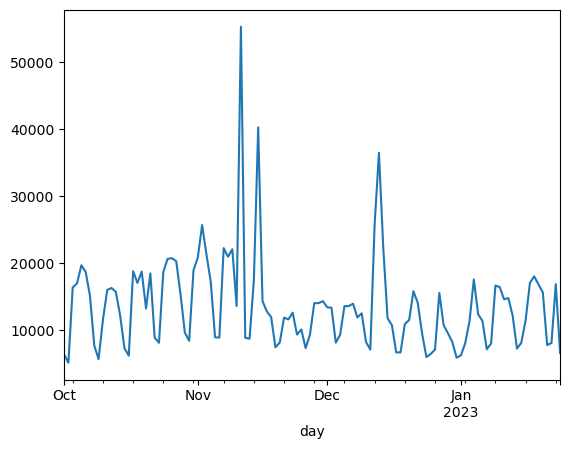

In [107]:
df.groupby(by='day')["prob_obs_num_responses"].sum().plot()

<AxesSubplot:>

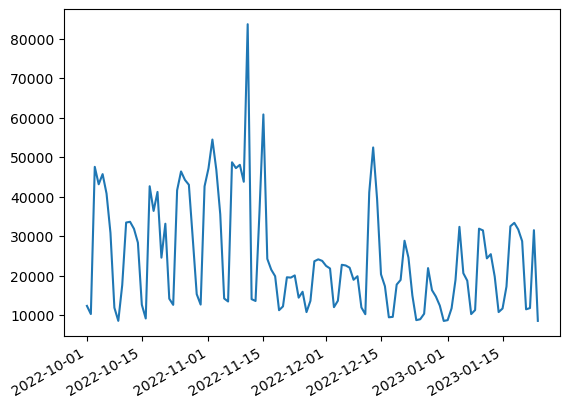

In [91]:
abc = df.sort_values(by='total_prob')
abc.day.value_counts().plot()

In [55]:
domain = 'google.com'  #oui-000199d.com
test = df.loc[df.index==domain]
test.sort_values(by='total_prob')

,day,num_clients,num_responses,num_shieldid,num_dns_qname,client_sum_group,responses_sum_group,shield_sum_group,prob_obs_num_clients,prob_obs_num_responses,prob_obs_num_shield,total_prob
dns_qdomainname,,,,,,,,,,,,
google.com,2022-10-03,186910,12070363,59,416,280762-15442591,40126158-589782974,2664-6151,0.003867,0.014877,0.000341,1.960351e-08
google.com,2022-10-19,159934,30375310,57,439,280762-15442591,40126158-589782974,2664-6151,0.005936,0.003719,0.001227,2.708019e-08
google.com,2022-11-01,158202,3657913,61,435,280762-15442591,40126158-589782974,2664-6151,0.006296,0.069270,0.000068,2.971869e-08
google.com,2022-11-07,156319,3393158,61,412,280762-15442591,40126158-589782974,2664-6151,0.006745,0.073222,0.000068,3.365791e-08
google.com,2022-10-18,139573,37042735,56,502,280762-15442591,40126158-589782974,2664-6151,0.008004,0.002325,0.002317,4.311062e-08
...,...,...,...,...,...,...,...,...,...,...,...,...
google.com,2022-12-26,5671,804501,45,194,280762-15442591,40126158-589782974,2664-6151,0.354169,0.324500,0.090568,1.040882e-02
google.com,2022-12-31,3258,810842,45,197,280762-15442591,40126158-589782974,2664-6151,0.455796,0.322176,0.090568,1.329965e-02
google.com,2023-01-01,2985,805280,45,193,280762-15442591,40126158-589782974,2664-6151,0.471265,0.323570,0.090568,1.381055e-02


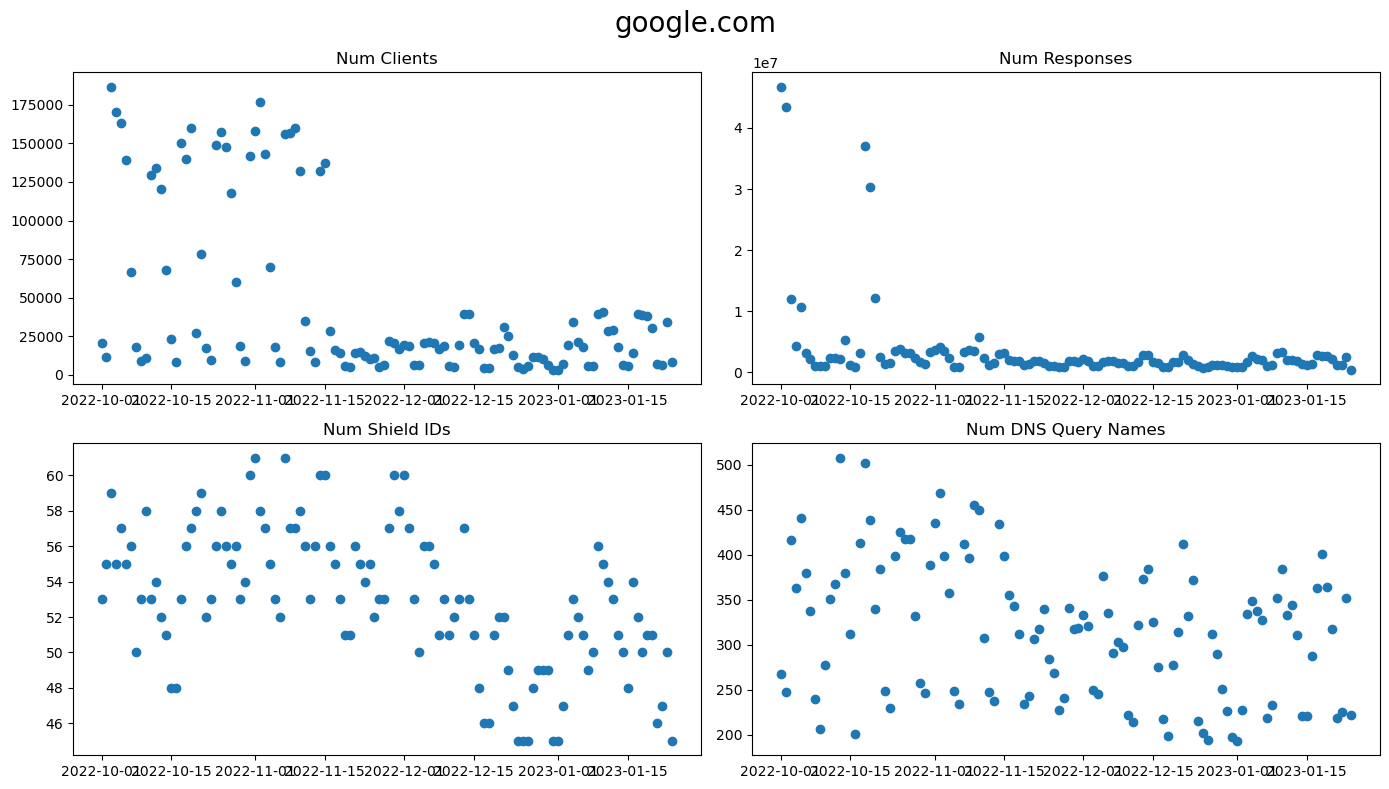

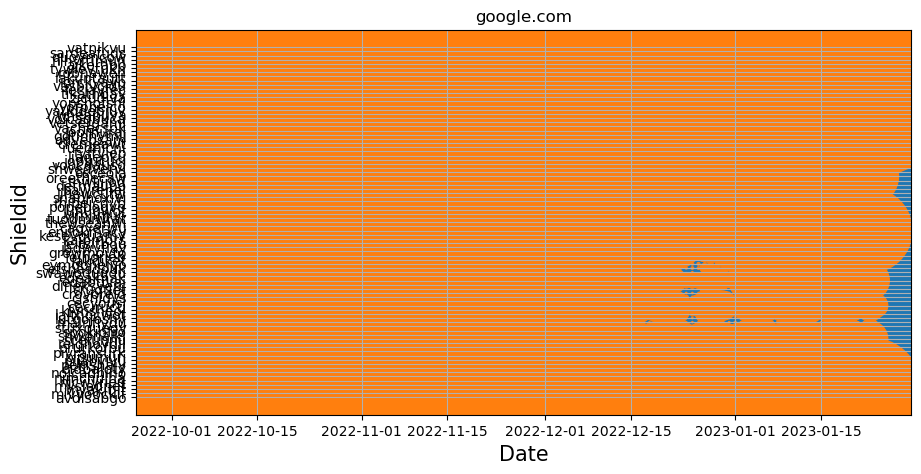

In [56]:
fig, axs = plt.subplots(2, 2, figsize=(14, 8))

axs[(0,0)].scatter(test.day, test.num_clients)
axs[(0,0)].set_title('Num Clients')

axs[(0,1)].scatter(test.day, test.num_responses)
axs[(0,1)].set_title('Num Responses')

axs[(1,0)].scatter(test.day, test.num_shieldid)
axs[(1,0)].set_title('Num Shield IDs')

axs[(1,1)].scatter(test.day, test.num_dns_qname)
axs[(1,1)].set_title('Num DNS Query Names')

plt.suptitle(str(domain), fontsize=20)
plt.tight_layout()
plt.show()

def get_domain_case_new(data, domain_name):    
    
    datatemp = data.loc[data.dns_qdomainname==domain_name]
    
    # df1 sums by domain name and day
    df1 = datatemp.groupby(by=['dns_qdomainname','day','shieldid']).sum()

    # df2 counts unique query names by domain name and day
    df2 = datatemp.groupby(by=['dns_qdomainname','day','shieldid'])['dns_qname'].nunique()
    df2 = pd.DataFrame(df2)
    df2.rename(columns={'dns_qname': 'num_dns_qname'}, inplace=True)

    # Concatenate df1 and df2 into df
    domain_case_new = pd.concat([df1, df2], axis=1)
    domain_case_new.reset_index(level=1, inplace=True)
    domain_case_new.reset_index(level=1, inplace=True)
    
    from itertools import product

    # Create lists of all unique values in columns 
    l1 = [domain_name]
    l2 = list(data.day.unique())
    l3 = list(domain_case_new.shieldid.unique())
    l4 = [0]
    l5 = [0]
    l6 = [0]

    _ = pd.DataFrame(list(product(l1, l2, l3, l4, l5, l6)), columns=['dns_qdomainname', 'day', 'shieldid', 'num_clients', 'num_responses', 'num_dns_qname'])
    _.set_index(list(_)[0], inplace=True)

    domain_case_new = pd.concat([domain_case_new, _])

    domain_case_new = domain_case_new.sort_values('day')

    return domain_case_new

domain_case_new = get_domain_case_new(data, domain)

# Plot
plt.figure(figsize=(10,5))
plt.xlabel('Date', fontsize=15)
plt.ylabel('Shieldid', fontsize=15)
plt.title(domain)
plt.scatter(domain_case_new.day, domain_case_new.shieldid, s=domain_case_new.num_responses)
plt.scatter(domain_case_new.day, domain_case_new.shieldid, s=domain_case_new.num_clients)
plt.grid(axis='both')